In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *
import torchvision.models as tmodels

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from scipy.misc import imsave, imread

import os
import sys

sys.path.insert(0, '/home/santhosr/Documents/Birad/FastAI/RaceClassification/' )

from utils import *

inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)


df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
df2.Medview_Race = 'White'
truth = pd.concat([df1,df2],sort=True)

In [2]:
df1.Medview_Race.value_counts()

African American         10369
White                     2416
Other                      214
Asian                      205
Unknown                     67
Hispanic Latino/White       51
Hispanic Latino/Black       22
East Indian                 16
Pacific Island               6
American Indian              5
Name: Medview_Race, dtype: int64

In [3]:
df2.Medview_Race.value_counts()

White    3500
Name: Medview_Race, dtype: int64

In [4]:
truth.Medview_Race.value_counts()

African American         10369
White                     5916
Other                      214
Asian                      205
Unknown                     67
Hispanic Latino/White       51
Hispanic Latino/Black       22
East Indian                 16
Pacific Island               6
American Indian              5
Name: Medview_Race, dtype: int64

In [5]:
truth = truth.drop_duplicates(subset=['DummyID'])

In [6]:
truth.Medview_Race.value_counts()

African American         10369
White                     5198
Other                      214
Asian                      205
Unknown                     67
Hispanic Latino/White       51
Hispanic Latino/Black       22
East Indian                 16
Pacific Island               6
American Indian              5
Name: Medview_Race, dtype: int64

In [2]:
df1.head()

,BMI,Medview_Race,ScreenDate,Age,DummyID,Density_Overall
0,27.1,White,3/23/2011,67.8,2508626,2
1,25.7,White,6/2/2011,58.8,2505738,2
2,28.1,White,5/24/2011,56.4,2547962,2
3,31.8,White,5/6/2011,51.7,2575490,2
4,27.5,Other,5/5/2011,63.7,2591080,2


In [3]:
df2.head()

,DummyID,ScreenDate,Medview_Race,Age,Density_Overall,BMI
0,2505738,6/2/2011,White,58.8,2.0,25.7
1,2575490,5/6/2011,White,51.7,2.0,31.8
2,2608662,5/10/2011,White,57.4,3.0,22.0
3,2609320,4/28/2011,White,55.4,3.0,23.0
4,2610496,5/9/2011,White,57.3,1.0,27.1


(0, 80)

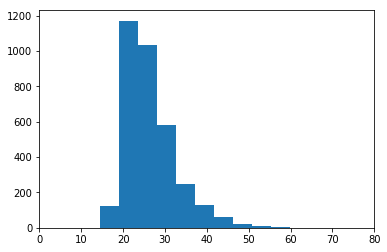

In [7]:
plt.hist(df2.BMI)
plt.xlim(0,80)

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0, 80)

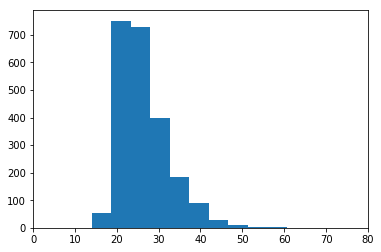

In [8]:
plt.hist(df1[df1.Medview_Race=='White'].BMI)
plt.xlim(0,80)

(0, 80)

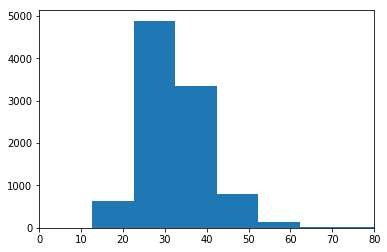

In [9]:
plt.hist(df1[df1.Medview_Race=='African American'].BMI)
plt.xlim(0,80)

In [10]:
df1PatientList = set(df1[df1.Medview_Race=='White']['DummyID'].values)

df2PatientList = set(df2['DummyID'].values)

In [11]:
q1 = df1PatientList.intersection(df2PatientList)

In [12]:
len(q1)

696

In [7]:
q2 = set(df1.DummyID).intersection(set(df2.DummyID.values))

In [8]:
extraPatients = list(q2.difference(q1))

In [16]:
len(df1[df1.DummyID.isin(extraPatients)]['DummyID'].values)

22

In [13]:
df2[df2.DummyID.isin(extraPatients)].sort_values('DummyID')

,DummyID,ScreenDate,Medview_Race,Age,Density_Overall,BMI
284,4121127,11/21/2011,White,42.4,3.0,32.0
716,5127892,11/30/2012,White,42.7,2.0,27.2
705,5129833,11/8/2012,White,47.5,2.0,31.1
889,5265592,1/18/2013,White,71.0,2.0,30.1
1333,75241874,4/23/2013,White,46.6,2.0,36.9
1430,75324130,5/31/2013,White,64.4,2.0,25.4
2093,75834114,11/27/2013,White,48.4,3.0,26.8
2196,75913620,1/20/2014,White,65.8,2.0,24.1
2313,76007543,1/31/2014,White,41.1,2.0,23.2
2593,76231025,4/18/2014,White,49.3,3.0,29.0


In [13]:
df1[df1.DummyID.isin(q1)].head()

,BMI,Medview_Race,ScreenDate,Age,DummyID,Density_Overall
1,25.7,White,6/2/2011,58.8,2505738,2
3,31.8,White,5/6/2011,51.7,2575490,2
6,23.7,White,5/10/2011,57.4,2608662,3
10,22.7,White,8/12/2011,58.1,2898827,3
12,28.3,White,10/10/2011,67.4,2036311,2


In [15]:
t = pd.read_csv('/home/santhosr/Documents/Birad/Breast_density_data.csv')

In [16]:
t.head()

,File Analyzed,Manufacturer,Laterality,ViewPosition,BreastArea(sqcm),DenseArea(sqcm),BreastDensity(%)
0,4998138_R_CC_1,HOLOGIC Inc.,Right,CC,125.592012,13.221884,10.527647
1,4998138_L_MLO_1,HOLOGIC Inc.,Left,MLO,146.640624,7.212244,4.918312
2,4998138_R_XCCL_1,HOLOGIC Inc.,Right,XCCL,132.243176,11.318944,8.559189
3,4998138_R_MLO_1,HOLOGIC Inc.,Right,MLO,121.258852,6.549764,5.401473
4,4998138_L_CC_1,HOLOGIC Inc.,Left,CC,154.714768,29.560804,19.106647


### Create Dataset Analysis

In [38]:
def getBMIData(aa, white, bmi_min, bmi_max):
    
    aaSub = aa[(aa.BMI>=bmi_min) & (aa.BMI<bmi_max)]
    whiteSub = white[(white.BMI>=bmi_min) & (white.BMI<bmi_max)]

    maxSamples = min(len(whiteSub), len(aaSub))
    
    if maxSamples==0:
        return pd.DataFrame()
    
    
    #Subsetting to keep only maxSamples number of samples in each subset
    aaSub = aaSub.sample(n=maxSamples, replace = False)
    whiteSub = whiteSub.sample(n=maxSamples, replace = False)
    
    #Figuring out the number of samples in train/valid
    numTrain = int(0.8*maxSamples)
    numValid = maxSamples - numTrain
    
    
    
    aaTrain = np.random.choice(aaSub.DummyID, numTrain,replace = False)
    whiteTrain = np.random.choice(whiteSub.DummyID, numTrain,replace = False)
    
    aaValid = np.array(list(set(aaSub.DummyID.values).difference(set(aaTrain))))
    whiteValid = np.array(list(set(whiteSub.DummyID.values).difference(set(whiteTrain))))
    
    d =  pd.concat([
        pd.DataFrame({'DummyID':aaTrain,'train':False}),
        pd.DataFrame({'DummyID':whiteTrain,'train':False}),
        pd.DataFrame({'DummyID':aaValid,'train':True}),
        pd.DataFrame({'DummyID':whiteValid,'train':True})
    ])
    
    print("Max Samples : {} numTrain  : {} df len : {}".format(maxSamples, numTrain, len(d)))
    
    return d
    
    
    

In [41]:
def createBMIDataset(bmi_buckets = [0,20,30,40,50,55,60,100]):
    
    patientList = []
    fullFileList = []

    inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
    truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

    inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
    truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

    df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
    df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)


    df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
    df2.Medview_Race = 'White'

    ## Removing IDs from df2 which are already present in df1
    idList = list(df1.DummyID.values)
    df2 = df2[~df2.DummyID.isin(idList)]

    truth = pd.concat([df1,df2],sort=True)

    ## Reading from set 1
    for i in range(1,5):

        folder = os.path.join(inputFolder1,str(i))
        fileList = os.listdir(folder)
        fileList = [os.path.join('FullRes',str(i),x) for x in fileList]
        fullFileList = fullFileList + fileList
#         print(len(fileList))

        patientList = patientList + [int(x.split("/")[-1].split("_")[0]) for x in fileList]

    patientList1 = patientList.copy()
    ## Reading from set 2
    print(len(patientList))

    fileList= os.listdir(inputFolder2)
    fileList = [os.path.join('PennExtra_3500',x) for x in fileList]
    d = pd.DataFrame(fileList)
    d[1] = d[0].apply(lambda x : int(x.split("/")[1].split("_")[0]))
    d = d[d[1].isin(df2.DummyID.values)]
    fileList = list(d[0].values)
    fullFileList += list(d[0].values)

    patientList += [int(x.split("/")[-1].split("_")[0]) for x in fileList]
    print(len(patientList))

    patientList2 = patientList.copy()

    #Retaining only the patients with 4 views
    k=pd.Series(patientList).value_counts().reset_index()
    patientList = k[k[0]==4]['index'].values
    print("total number of patients",len(patientList))

    patientList = np.array(list(set(patientList)))
    df = pd.DataFrame({'DummyID':patientList})
    df = pd.merge(df,truth, how='left')
    df1 = df1.copy()
    df = df.drop_duplicates(subset=['DummyID'])

    #Creates equal number of patients from White and AA groups
    white = df[df.Medview_Race=='White']
    AA = df[df.Medview_Race=='African American']

    
    outputDf = pd.DataFrame()

    for i in range(len(bmi_buckets)-1):
        out = getBMIData(AA,white, bmi_buckets[i], bmi_buckets[i+1])

        outputDf = pd.concat([outputDf, out])
        
    temp = pd.DataFrame(fullFileList)
    temp.columns = ['filename']

    temp['DummyID'] = temp.filename.apply(lambda x : int(x.split("/")[-1].split("_")[0]))

    trainTemp = temp[temp.DummyID.isin(outputDf[outputDf.train==False].DummyID.values)]
    validTemp = temp[temp.DummyID.isin(outputDf[outputDf.train==True].DummyID.values)]
    
    trainTemp['train'] = False
    validTemp['train'] = True

    df= pd.concat([trainTemp, validTemp], sort = True)

    #Shuffling data
    index = list(range(len(df)))
    np.random.shuffle(index)
    df = df.iloc[index]
    
    return df
    
    
    

In [26]:
df = createBMIDataset()

8405
30751
13438
816
53410
64525
total number of patients 16107
Max Samples : 185 numTrain  : 148 df len : 370
Max Samples : 3412 numTrain  : 2729 df len : 6824
Max Samples : 930 numTrain  : 744 df len : 1860
Max Samples : 164 numTrain  : 131 df len : 328
Max Samples : 18 numTrain  : 14 df len : 36
Max Samples : 1 numTrain  : 0 df len : 2


/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
df = pd.merge(df,truth[['DummyID','BMI','Medview_Race']],on='DummyID',how='left')

In [29]:
len(df)

37680

(0, 80)

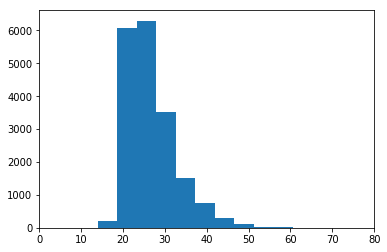

In [11]:
plt.hist(df[df.Medview_Race=='White'].BMI)
plt.xlim(0,80)

(0, 80)

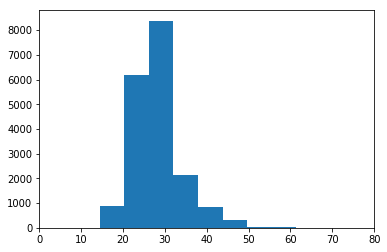

In [12]:
plt.hist(df[df.Medview_Race=='African American'].BMI)
plt.xlim(0,80)

In [13]:
df[df.Medview_Race=='African American'].BMI.describe()

count    18840.000000
mean        28.129682
std          5.698386
min          2.700000
25%         24.600000
50%         27.500000
75%         29.900000
max         61.400000
Name: BMI, dtype: float64

In [14]:
df[df.Medview_Race=='White'].BMI.describe()

count    18840.000000
mean        26.806454
std          5.962549
min         14.000000
25%         22.500000
50%         25.300000
75%         29.600000
max         60.600000
Name: BMI, dtype: float64

In [15]:
df[(df.Medview_Race=='African American') & (df.BMI.between(0,20))].BMI.describe()

count    772.000000
mean      18.405181
std        2.199227
min        2.700000
25%       18.100000
50%       19.000000
75%       19.500000
max       20.000000
Name: BMI, dtype: float64

In [16]:
df[(df.Medview_Race=='African American') & (df.BMI.between(0,20))].BMI.describe()

count    772.000000
mean      18.405181
std        2.199227
min        2.700000
25%       18.100000
50%       19.000000
75%       19.500000
max       20.000000
Name: BMI, dtype: float64

In [30]:
df[(df.Medview_Race=='African American') & (df.BMI.between(0,20))].DummyID.nunique()

193

In [31]:
df[(df.Medview_Race=='White') & (df.BMI.between(0,20))].DummyID.nunique()

219

In [36]:
df[(df.Medview_Race=='White') & (df.BMI>=20) & (df.BMI<30)].BMI.mean()

24.403106682297288

In [37]:
df[(df.Medview_Race=='African American') & (df.BMI>=20) & (df.BMI<30)].BMI.mean()

26.125967174677413

### New Dataset

In [12]:
inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

fileList= os.listdir(inputFolder2)
fileList = [os.path.join('PennExtra_3500',x) for x in fileList]
# fullFileList += fileList

patientList = [int(x.split("/")[-1].split("_")[0]) for x in fileList]
print(len(patientList))

k=pd.Series(patientList).value_counts().reset_index()
patientList = k[k[0]==4]['index'].values
print("total number of patients",len(patientList))

patientList2 = patientList.copy()

13979
total number of patients 3489


In [20]:
'PennExtra_3500/4077998_FOR-PROCESSING_R_MLO_1.jpg' in fileList

True

In [21]:
'PennExtra_3500/4077998_FOR-PROCESSING_R_MLO_1.jpg' in fileList

True

In [22]:
inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

patientList = []

for i in range(1,5):
    folder = os.path.join(inputFolder1,str(i))
    fileList = os.listdir(folder)
    fileList = [os.path.join('FullRes',str(i),x) for x in fileList]
    print(len(fileList))

    patientList = patientList + [int(x.split("/")[-1].split("_")[0]) for x in fileList]

k=pd.Series(patientList).value_counts().reset_index()
patientList = k[k[0]==4]['index'].values
print("total number of patients",len(patientList))

patientList1 = patientList.copy()

8405
30753
13438
816
total number of patients 13333


In [72]:
idList = list(df1.DummyID.values)

len(df2[~df2.DummyID.isin(idList)])

2782

In [73]:
len(df2)-2782

718

In [58]:
len(df1[df1.DummyID.isin(patientList1)][df1.Medview_Race=='White'] )

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


2411

In [57]:
len(df2[df2.DummyID.isin(patientList2)])

3489

In [59]:
2411+3489

5900

In [60]:
len(set(patientList1).intersection(set(patientList2)))

714

In [23]:
patientList = []
fullFileList = []

inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)


df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
df2.Medview_Race = 'White'

## Removing IDs from df2 which are already present in df1
idList = list(df1.DummyID.values)
df2 = df2[~df2.DummyID.isin(idList)]

truth = pd.concat([df1,df2],sort=True)

## Reading from set 1
for i in range(1,5):

    folder = os.path.join(inputFolder1,str(i))
    fileList = os.listdir(folder)
    fileList = [os.path.join('FullRes',str(i),x) for x in fileList]
    fullFileList = fullFileList + fileList
    print(len(fileList))

    patientList = patientList + [int(x.split("/")[-1].split("_")[0]) for x in fileList]

patientList1 = patientList.copy()
## Reading from set 2
print(len(patientList))

fileList= os.listdir(inputFolder2)
fileList = [os.path.join('PennExtra_3500',x) for x in fileList]

d = pd.DataFrame(fileList)
d[1] = d[0].apply(lambda x : int(x.split("/")[1].split("_")[0]))
d = d[d[1].isin(df2.DummyID.values)]

fullFileList += list(d[0].values)

patientList += [int(x.split("/")[-1].split("_")[0]) for x in fileList]
print(len(patientList))

patientList2 = patientList.copy()

#Retaining only the patients with 4 views
k=pd.Series(patientList).value_counts().reset_index()
patientList = k[k[0]>=4]['index'].values
print("total number of patients",len(patientList))

8405
30753
13438
816
53412
67391
total number of patients 16112


In [25]:
len(fileList)

13979

In [30]:
d = pd.DataFrame(fileList)
d[1] = d[0].apply(lambda x : int(x.split("/")[1].split("_")[0]))
d = d[d[1].isin(df2.DummyID.values)]

In [31]:
d.head()

,0,1
0,PennExtra_3500/4002346_FOR-PROCESSING_L_MLO_1.jpg,4002346
1,PennExtra_3500/76323689_FOR-PROCESSING_R_CC_1.jpg,76323689
2,PennExtra_3500/75106103_FOR-PROCESSING_R_MLO_1...,75106103
3,PennExtra_3500/4690229_FOR-PROCESSING_L_MLO_1.jpg,4690229
4,PennExtra_3500/3755652_FOR-PROCESSING_L_CC_1.jpg,3755652


In [38]:
list(d[0].values)

['PennExtra_3500/4002346_FOR-PROCESSING_L_MLO_1.jpg',
 'PennExtra_3500/76323689_FOR-PROCESSING_R_CC_1.jpg',
 'PennExtra_3500/75106103_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/4690229_FOR-PROCESSING_L_MLO_1.jpg',
 'PennExtra_3500/3755652_FOR-PROCESSING_L_CC_1.jpg',
 'PennExtra_3500/76609436_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/4082563_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/75869431_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/75199428_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/75319978_FOR-PROCESSING_R_CC_1.jpg',
 'PennExtra_3500/76421522_FOR-PROCESSING_L_MLO_1.jpg',
 'PennExtra_3500/75277656_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/76916846_FOR-PROCESSING_L_CC_1.jpg',
 'PennExtra_3500/5183007_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/75699172_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/76912298_FOR-PROCESSING_R_MLO_1.jpg',
 'PennExtra_3500/76374773_FOR-PROCESSING_L_CC_1.jpg',
 'PennExtra_3500/76811510_FOR-PROCESSING_L_MLO_1.jpg',
 'PennExtra_3500/768

### Error while reading files

In [9]:
errorFiles = []



fullFileList = []

inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)


df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
df2.Medview_Race = 'White'

## Removing IDs from df2 which are already present in df1
idList = list(df1.DummyID.values)
df2 = df2[~df2.DummyID.isin(idList)]

truth = pd.concat([df1,df2],sort=True)

## Reading from set 1
for i in range(1,5):

    folder = os.path.join(inputFolder1,str(i))
    fileList = os.listdir(folder)
    fileList = [os.path.join('FullRes',str(i),x) for x in fileList]
    fullFileList = fullFileList + fileList


for i in fullFileList:
    try:
        img=imread(os.path.join('/home/santhosr/Documents/Birad/ProcessedData/',i))
    except:
        errorFiles.append(i)

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [11]:
len(errorFiles)

2

In [12]:
errorFiles

['FullRes/2/4077998_R_MLO_1.jpg', 'FullRes/2/4077998_L_MLO_1.jpg']

### Creating combined File

In [17]:
inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)


df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
df2.Medview_Race = 'White'

In [43]:
e.head()

,Unnamed: 0,VolparaVersion,Folder,ImageName,DetectorID,XraySystem,ManufacturersModelName,PatientID,PatientDOB,PatientAge,...,MaximumDenseVolumeIn1Cm2AreaInCm3,MaximumDensity1Cm2AreaDistanceFromSuperiorEdgeInMm,MaximumDensity1Cm2AreaDistanceFromMedialEdgeInMm,MaximumDensity1Cm2AreaDistanceFromPosteriorEdgeInMm,DoseCalibrationError,MeasuredHVLInMmAl,MeasuredEntranceDoseInmGy,DoseCalibrationUsedDateTime,DoseCalculationBasis,DummyID
0,0,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_L_CC_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,1.047380,NaN,130.9,30.45,NaN,NaN,NaN,NaN,NaN,2036311
1,1,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_L_MLO_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,1.639360,127.05,NaN,42.35,NaN,NaN,NaN,NaN,NaN,2036311
2,2,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_L_MLO_2,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,1.014270,149.80,NaN,30.80,NaN,NaN,NaN,NaN,NaN,2036311
3,3,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_R_CC_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,0.842166,NaN,135.1,33.60,NaN,NaN,NaN,NaN,NaN,2036311
4,4,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_R_MLO_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,1.504580,110.95,NaN,42.00,NaN,NaN,NaN,NaN,NaN,2036311


In [22]:
df1.head()

,BMI,Medview_Race,ScreenDate,Age,DummyID,Density_Overall
0,27.1,White,3/23/2011,67.8,2508626,2
1,25.7,White,6/2/2011,58.8,2505738,2
2,28.1,White,5/24/2011,56.4,2547962,2
3,31.8,White,5/6/2011,51.7,2575490,2
4,27.5,Other,5/5/2011,63.7,2591080,2


In [30]:
densitydf1 = pd.read_csv('/home/santhosr/Documents/Birad/Breast_density_data.csv')
densitydf2 = pd.read_csv('/home/santhosr/Documents/Birad/3500_studies_VolparaOutput.csv')

densitydf1['DummyID'] = densitydf1['File Analyzed'].apply(lambda x : int(x.split("_")[0]))
densitydf2['DummyID'] = densitydf2.ImageName.apply(lambda x : int(x.split("_")[0]))

In [32]:
len(set(densitydf1.DummyID.values).intersection(df1.DummyID.values))

13371

In [33]:
len(set(densitydf1.DummyID.values).intersection(df2.DummyID.values))

3500

In [34]:
len(set(e.DummyID.values).intersection(df1.DummyID.values))

13309

In [35]:
len(set(e.DummyID.values).intersection(df2.DummyID.values))

712

In [36]:
len(set(densitydf2.DummyID.values).intersection(df1.DummyID.values))

718

In [37]:
len(set(densitydf2.DummyID.values).intersection(df2.DummyID.values))

3500

In [38]:
len(set(df1.DummyID.values).intersection(df2.DummyID.values))

718

In [39]:
(set(densitydf2.DummyID.values).intersection(df1.DummyID.values)).difference(set(e.DummyID.values).intersection(df2.DummyID.values))

{3709369, 3714326, 3718667, 3724128, 3724149, 3726542}

In [40]:
3709369 in df1.DummyID.values

True

In [41]:
3709369 in df2.DummyID.values

True

In [29]:
densitydf1.head()

,File Analyzed,Manufacturer,Laterality,ViewPosition,BreastArea(sqcm),DenseArea(sqcm),BreastDensity(%),DummyID
0,4998138_R_CC_1,HOLOGIC Inc.,Right,CC,125.592012,13.221884,10.527647,4998138
1,4998138_L_MLO_1,HOLOGIC Inc.,Left,MLO,146.640624,7.212244,4.918312,4998138
2,4998138_R_XCCL_1,HOLOGIC Inc.,Right,XCCL,132.243176,11.318944,8.559189,4998138
3,4998138_R_MLO_1,HOLOGIC Inc.,Right,MLO,121.258852,6.549764,5.401473,4998138
4,4998138_L_CC_1,HOLOGIC Inc.,Left,CC,154.714768,29.560804,19.106647,4998138


,VolparaVersion,Folder,ImageName,DetectorID,XraySystem,ManufacturersModelName,PatientID,PatientDOB,PatientAge,AccessionNumber,...,MaximumPercentDensityIn1Cm2Area,MaximumDenseVolumeIn1Cm2AreaInCm3,MaximumDensity1Cm2AreaDistanceFromSuperiorEdgeInMm,MaximumDensity1Cm2AreaDistanceFromMedialEdgeInMm,MaximumDensity1Cm2AreaDistanceFromPosteriorEdgeInMm,DoseCalibrationError,MeasuredHVLInMmAl,MeasuredEntranceDoseInmGy,DoseCalibrationUsedDateTime,DoseCalculationBasis
0,1.5.4.0 | 9561 |,V:\RADIOMICS\DiskFromUpenn_103119\Deep_Learnin...,76175745_FOR-PROCESSING_L_MLO_1,MM60208,Hologic,Selenia Dimensions,7109486638,Unknown,59,76175745,...,29.03230,1.645040,108.15,NaN,50.40,NaN,NaN,NaN,NaN,NaN
1,1.5.4.0 | 9561 |,V:\RADIOMICS\DiskFromUpenn_103119\Deep_Learnin...,75159878_FOR-PROCESSING_R_CC_1,MM601087,Hologic,Selenia Dimensions,7108282100,Unknown,66,75159878,...,6.49464,0.434911,NaN,140.70,90.65,NaN,NaN,NaN,NaN,NaN
2,1.5.4.0 | 9561 |,V:\RADIOMICS\DiskFromUpenn_103119\Deep_Learnin...,75746314_FOR-PROCESSING_R_CC_1,MM60208,Hologic,Selenia Dimensions,7108649653,Unknown,70,75746314,...,11.58090,0.727787,NaN,112.35,12.60,NaN,NaN,NaN,NaN,NaN
3,1.5.4.0 | 9561 |,V:\RADIOMICS\DiskFromUpenn_103119\Deep_Learnin...,75096435_FOR-PROCESSING_L_CC_1,MM601087,Hologic,Selenia Dimensions,7109796870,Unknown,52,75096435,...,56.05020,2.887220,NaN,163.80,15.05,NaN,NaN,NaN,NaN,NaN
4,1.5.4.0 | 9561 |,V:\RADIOMICS\DiskFromUpenn_103119\Deep_Learnin...,3616568_FOR-PROCESSING_R_MLO_2,MM601087,Hologic,Selenia Dimensions,61827269,Unknown,51,3616568,...,15.93200,1.050470,107.80,NaN,22.05,NaN,NaN,NaN,NaN,NaN


In [21]:
e=pd.read_csv('/home/santhosr/Documents/Birad/FastAI/RaceClassification/Final.csv')
e.head()

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,VolparaVersion,Folder,ImageName,DetectorID,XraySystem,ManufacturersModelName,PatientID,PatientDOB,PatientAge,...,MaximumPercentDensityIn1Cm2Area,MaximumDenseVolumeIn1Cm2AreaInCm3,MaximumDensity1Cm2AreaDistanceFromSuperiorEdgeInMm,MaximumDensity1Cm2AreaDistanceFromMedialEdgeInMm,MaximumDensity1Cm2AreaDistanceFromPosteriorEdgeInMm,DoseCalibrationError,MeasuredHVLInMmAl,MeasuredEntranceDoseInmGy,DoseCalibrationUsedDateTime,DoseCalculationBasis
0,0,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_L_CC_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,16.3976,1.047380,NaN,130.9,30.45,NaN,NaN,NaN,NaN,NaN
1,1,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_L_MLO_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,25.2581,1.639360,127.05,NaN,42.35,NaN,NaN,NaN,NaN,NaN
2,2,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_L_MLO_2,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,16.4085,1.014270,149.80,NaN,30.80,NaN,NaN,NaN,NaN,NaN
3,3,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_R_CC_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,14.5975,0.842166,NaN,135.1,33.60,NaN,NaN,NaN,NaN,NaN
4,4,1.5.4.0 | 9561 |,V:\RADIOMICS\UPENN\Penn\Dicom1,2036311_R_MLO_1,MM601537,Hologic,Selenia Dimensions,61378623,Unknown,67,...,20.8634,1.504580,110.95,NaN,42.00,NaN,NaN,NaN,NaN,NaN


In [25]:
e['DummyID'] = e.ImageName.apply(lambda x : int(x.split("_")[0]))

15712.5

In [45]:
densitydf1.head()

,File Analyzed,Manufacturer,Laterality,ViewPosition,BreastArea(sqcm),DenseArea(sqcm),BreastDensity(%),DummyID
0,4998138_R_CC_1,HOLOGIC Inc.,Right,CC,125.592012,13.221884,10.527647,4998138
1,4998138_L_MLO_1,HOLOGIC Inc.,Left,MLO,146.640624,7.212244,4.918312,4998138
2,4998138_R_XCCL_1,HOLOGIC Inc.,Right,XCCL,132.243176,11.318944,8.559189,4998138
3,4998138_R_MLO_1,HOLOGIC Inc.,Right,MLO,121.258852,6.549764,5.401473,4998138
4,4998138_L_CC_1,HOLOGIC Inc.,Left,CC,154.714768,29.560804,19.106647,4998138
